In [6]:
from astropy.table import Table
from matplotlib import pyplot as plt
from astroquery.simbad import Simbad
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings("ignore")

plt.style.use('paper.mplstyle')
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [7]:
# Load the two preview files
table_old = Table.read("data/preview_preremove.txt", format="ascii.basic", delimiter="\t")
# table_new = Table.read("data/preview_afterremove.txt", format="ascii.basic", delimiter="\t")
table_new = Table.read("data/preview_afterremove_300725.txt", format="ascii.basic", delimiter="\t")

In [8]:
print(f"Old table has {len(table_old)} entries")
print(f"New table has {len(table_new)} entries")

# Get distinct values of OBSTECH 
obstech_old = set(table_old['OBSTECH'])
obstech_new = set(table_new['OBSTECH'])
print(f"Old table has {len(obstech_old)} distinct OBSTECH values: {obstech_old}")
print(f"New table has {len(obstech_new)} distinct OBSTECH values: {obstech_new}")

Old table has 3176 entries
New table has 3267 entries
Old table has 6 distinct OBSTECH values: {'IMAGE,CLASSICAL', 'IMAGE,DUAL', 'IMAGE,DUAL,CORONOGRAPHY', 'POLARIMETRY', 'POLARIMETRY,CORONOGRAPHY', 'IMAGE,CLASSICAL,CORONOGRAPHY'}
New table has 4 distinct OBSTECH values: {'IMAGE,DUAL,CORONOGRAPHY', 'IMAGE,CLASSICAL', 'IMAGE,CLASSICAL,CORONOGRAPHY', 'IMAGE,DUAL'}


In [9]:
ra_old = []
ra_new = []
dec_old = []
dec_new = []
file_old = []
file_new = []
obj_old = []
obj_new = []

for j, file in enumerate(table_new['FILE']):
    for i, file2 in enumerate(table_old['FILE']):
        file2 = file2.split('/')[-1]
        if file == file2:
            ra_old.append(table_old['RA'][i])
            dec_old.append(table_old['DEC'][i])
            ra_new.append(table_new['RA'][j])
            dec_new.append(table_new['DEC'][j])
            file_old.append(file)
            file_new.append(file2)
            obj_old.append(table_old['OBJECT'][i])
            obj_new.append(table_new['OBJECT'][j])

ra_old = np.array(ra_old)
ra_new = np.array(ra_new)
dec_old = np.array(dec_old)
dec_new = np.array(dec_new)

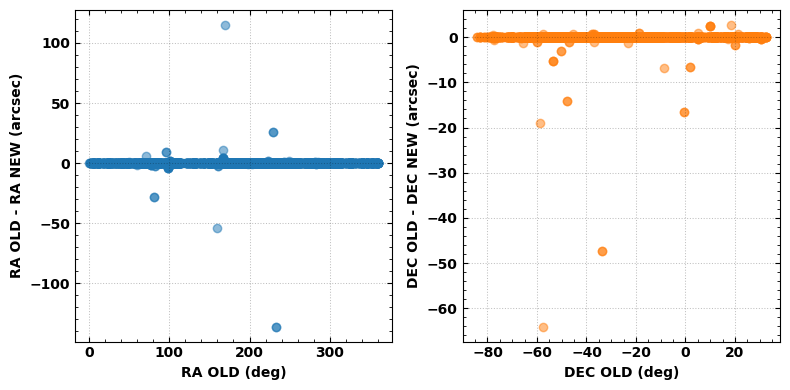

In [10]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra_old, (ra_old-ra_new)*3600, c='C0', alpha=0.5)
ax2.scatter(dec_old, (dec_old-dec_new)*3600, c='C1', alpha=0.5)

ax1.set_xlabel('RA OLD (deg)')
ax1.set_ylabel('RA OLD - RA NEW (arcsec)')
ax2.set_xlabel('DEC OLD (deg)')
ax2.set_ylabel('DEC OLD - DEC NEW (arcsec)')

fig.tight_layout()

In [11]:
ra_sim = []
dec_sim = []
obj_sim = []

for obj in tqdm(obj_new):

    result_table = Simbad.query_object(obj)

    try: 
        obj_sim_ = result_table["main_id"].value.data[0]
        ra_sim_  = result_table["ra"].data[0]
        dec_sim_ = result_table["dec"].data[0]
    
    except:
        obj_sim_ = "-"
        ra_sim_  = 0
        dec_sim_ = 0

    obj_sim.append(obj_sim_)
    ra_sim.append(ra_sim_)
    dec_sim.append(dec_sim_)

obj_sim = np.array(obj_sim)
ra_sim = np.array(ra_sim)
dec_sim = np.array(dec_sim)

100%|██████████| 3111/3111 [02:08<00:00, 24.28it/s]


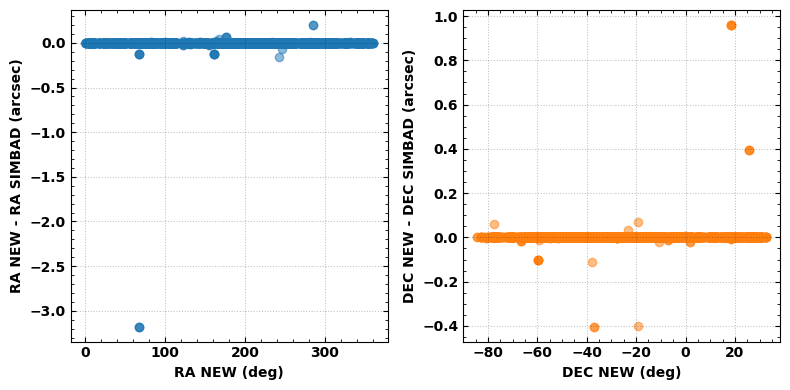

In [12]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mask = ra_sim != 0 
diff_ra = ra_new-ra_sim
diff_dec = dec_new-dec_sim

ax1.scatter(ra_new[mask], diff_ra[mask]*3600, c='C0', alpha=0.5)
ax2.scatter(dec_new[mask], diff_dec[mask]*3600, c='C1', alpha=0.5)

ax1.set_xlabel('RA NEW (deg)')
ax1.set_ylabel('RA NEW - RA SIMBAD (arcsec)')
ax2.set_xlabel('DEC NEW (deg)')
ax2.set_ylabel('DEC NEW - DEC SIMBAD (arcsec)')

fig.tight_layout()

In [13]:
data = [file_old, ra_old, ra_new, ra_sim, dec_old, dec_new, dec_sim, obj_old, obj_new, obj_sim]
names = ["file_old", "ra_old", "ra_new", "ra_sim", "dec_old", "dec_new", "dec_sim", "obj_old", "obj_new", "obj_sim"]

table_final = Table(data=data, names=names)

table_final.show_in_browser()
table_final.write("data/comparison_all.cvs", format='ascii.csv', overwrite=True)

In [34]:
print(f"Combined table has {len(table_final)} entries")

Combined table has 3111 entries


In [14]:
count = 0
ids = []
for i, (obj1, obj2, obj3) in enumerate(zip(obj_old, obj_new, obj_sim)):
    if obj1 != obj2:
        ids.append(i)
        count += 1

table_final[ids].show_in_browser()
table_final[ids].write("data/comparison_mismatch.cvs", format='ascii.csv', overwrite=True)

In [15]:
count = 0
ids = []
for i, (obj1, obj2, obj3) in enumerate(zip(obj_old, obj_new, obj_sim)):
    if obj3 == "-":
        ids.append(i)
        count += 1

print(f"Number of objects with no values (may include duplicates): {count}")
table_final[ids].show_in_browser()
table_final[ids].write("data/comparison_novalues.cvs", format='ascii.csv', overwrite=True)

Number of objects with no values (may include duplicates): 55


In [31]:
mask_diff1 = np.abs(table_final['ra_new'] - table_final['ra_sim']) > 0.1/3600
mask_diff2 = np.abs(table_final['dec_new'] - table_final['dec_sim']) > 0.1/3600
mask_zero = table_final['ra_sim'] != 0
table_final_ = table_final
table_final_['diff_ra_newsim'] = (table_final['ra_new'] - table_final['ra_sim']) *3600
table_final_['diff_dec_newsim'] = (table_final['dec_new'] - table_final['dec_sim']) *3600
table_final_[(mask_diff1 | mask_diff2) & mask_zero].show_in_browser()
table_final_[(mask_diff1 | mask_diff2) & mask_zero].write("data/comparison_differences_sim.csv", format='ascii.csv', overwrite=True)

In [35]:
mask_diff1 = np.abs(table_final['ra_new'] - table_final['ra_old']) > 0.1/3600
mask_diff2 = np.abs(table_final['dec_new'] - table_final['dec_old']) > 0.1/3600
table_final_ = table_final
table_final_['diff_ra_newold'] = (table_final['ra_new'] - table_final['ra_old']) *3600
table_final_['diff_dec_newold'] = (table_final['dec_new'] - table_final['dec_old']) *3600
table_final_[mask_diff1 | mask_diff2].show_in_browser()
table_final_[mask_diff1 | mask_diff2].write("data/comparison_differences_old.csv", format='ascii.csv', overwrite=True)
print(f"nubmer of entries with differences: {len(table_final_[mask_diff1 | mask_diff2])}")

nubmer of entries with differences: 74
